In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
from scikit_posthocs import posthoc_dunn
import pingouin as pg
from pingouin import ancova
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import data
in_market = pd.read_csv("In Market Auto Wrap Up Raw.csv")
in_market.columns = in_market.columns.str.replace(' ', '_')
in_market.columns = [x.lower() for x in in_market.columns]

In [3]:
#convert date object to datetime so we can slice
in_market['date'] = pd.to_datetime(in_market['date'])

#drop 08/13
in_market = in_market[in_market['date'] != '2023-08-13']

In [4]:
in_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27297 entries, 0 to 27296
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            27297 non-null  datetime64[ns]
 1   advertiser_id                   27297 non-null  int64         
 2   advertiser                      27297 non-null  object        
 3   site_id_(cm360)                 27297 non-null  int64         
 4   site_(cm360)                    27297 non-null  object        
 5   campaign_id                     27297 non-null  int64         
 6   campaign_external_id            27297 non-null  object        
 7   campaign                        27297 non-null  object        
 8   package/roadblock_id            27297 non-null  int64         
 9   package/roadblock               27297 non-null  object        
 10  placement_id                    27297 non-null  int64         
 11  pl

# In-Market Auto Performance By Group

In [6]:
in_market_group = in_market.groupby(['date','group'])[['impressions', 'clicks', 'spend', '3._lead:_total_conversions']].sum().reset_index()
in_market_group

,date,group,impressions,clicks,spend,3._lead:_total_conversions
0,2023-08-07,Control,2713.000000,7.000000,22.205064,0
1,2023-08-07,DCO,15717.000000,28.000000,87.171118,0
2,2023-08-08,Control,30994.000000,97.000000,329.650431,0
3,2023-08-08,DCO,118291.511059,375.993033,1050.545646,0
4,2023-08-09,Control,27691.000000,62.000000,235.185603,1
...,...,...,...,...,...,...
121,2023-10-11,DCO,206415.284892,723.992267,2172.479858,6
122,2023-10-12,Control,32937.000000,80.000000,300.065544,0
123,2023-10-12,DCO,227637.806545,823.984611,2546.606223,3
124,2023-10-13,Control,32971.000000,71.000000,299.365838,0


In [7]:
#create calculated fields for KPIs of interest
in_market_group['ctr'] = in_market_group['clicks'] / in_market_group['impressions']
in_market_group['cvr'] = in_market_group['3._lead:_total_conversions'] / in_market_group['clicks']
in_market_group['cpl'] = in_market_group['spend'] / in_market_group['3._lead:_total_conversions']

In [8]:
#replace Inf and NaN values with 0
for i in in_market_group.columns:
    in_market_group[i] = in_market_group[i].replace([np.inf, -np.inf], 0)
    in_market_group[i] = in_market_group[i].replace(np.nan, 0)

#summary stats
in_market_group.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
impressions,126.0,106181.332391,94758.264314,0.0,34797.250000,47029.500000,177451.943468,447034.177189
clicks,126.0,355.381229,338.794624,0.0,90.500000,156.500000,583.731577,1342.968149
spend,126.0,994.045015,912.361200,0.0,301.799731,496.033331,1578.350500,3905.689701
3._lead:_total_conversions,126.0,2.420635,2.492720,0.0,0.000000,2.000000,4.000000,11.000000
ctr,126.0,0.002989,0.001015,0.0,0.002547,0.003183,0.003614,0.004920
cvr,126.0,0.009301,0.014535,0.0,0.000000,0.005085,0.010030,0.083333
cpl,126.0,291.882329,351.174737,0.0,0.000000,211.188716,433.490146,1952.844851


In [10]:
#set plot figure size
sns.set(rc={'figure.figsize':(15,7)})
sns.set_style('white')

#set color palette to be AmFam colors
my_colors = ['#DD0031', '#0851A6', '#003A6D']
sns.set_palette(my_colors)

<Axes: xlabel='cpl', ylabel='Count'>

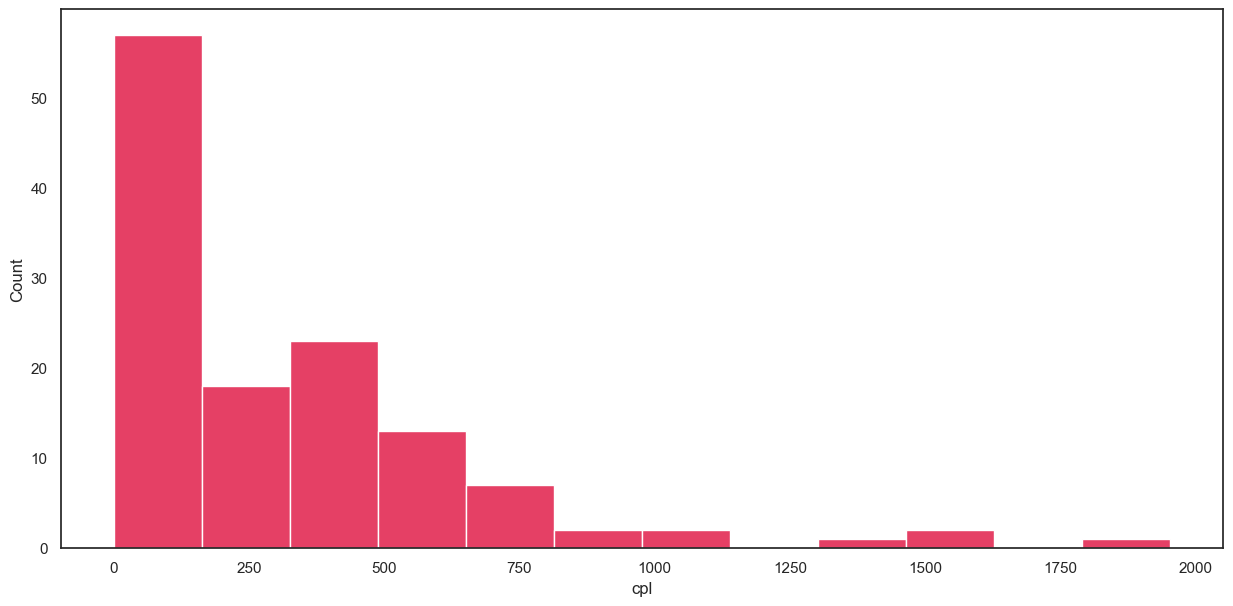

In [11]:
#create histogram of cpl
sns.histplot(in_market_group, x='cpl', kde=False)

<Axes: xlabel='3._lead:_total_conversions', ylabel='Count'>

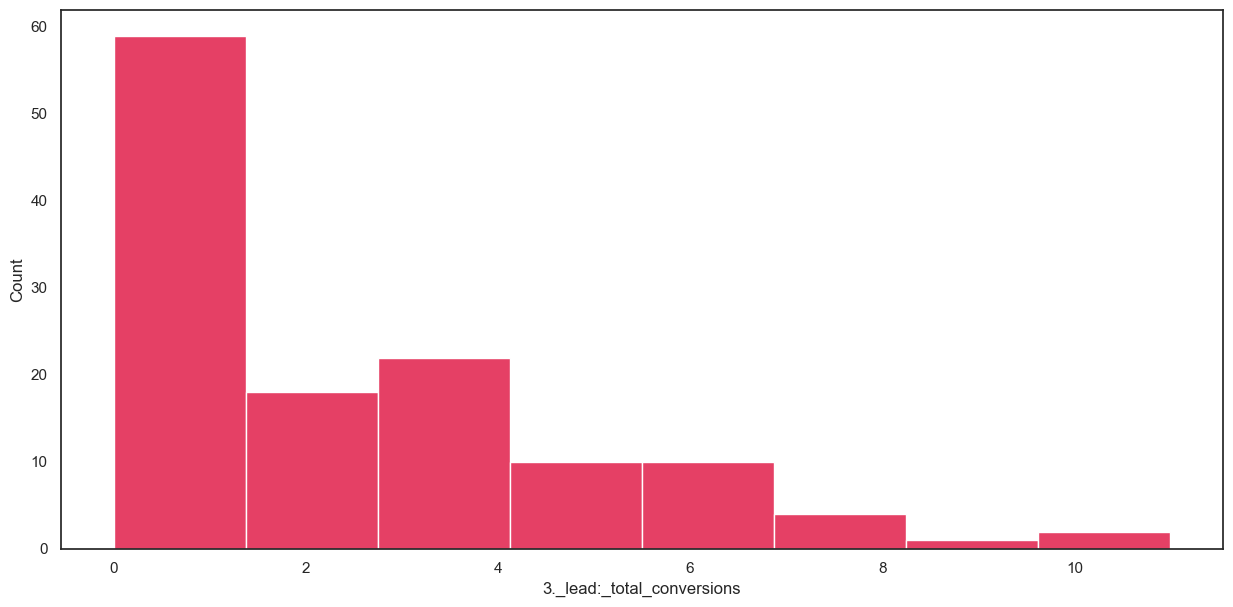

In [17]:
#create histogram of leads
sns.histplot(in_market_group, x='3._lead:_total_conversions', kde=False)

<Axes: xlabel='ctr', ylabel='Count'>

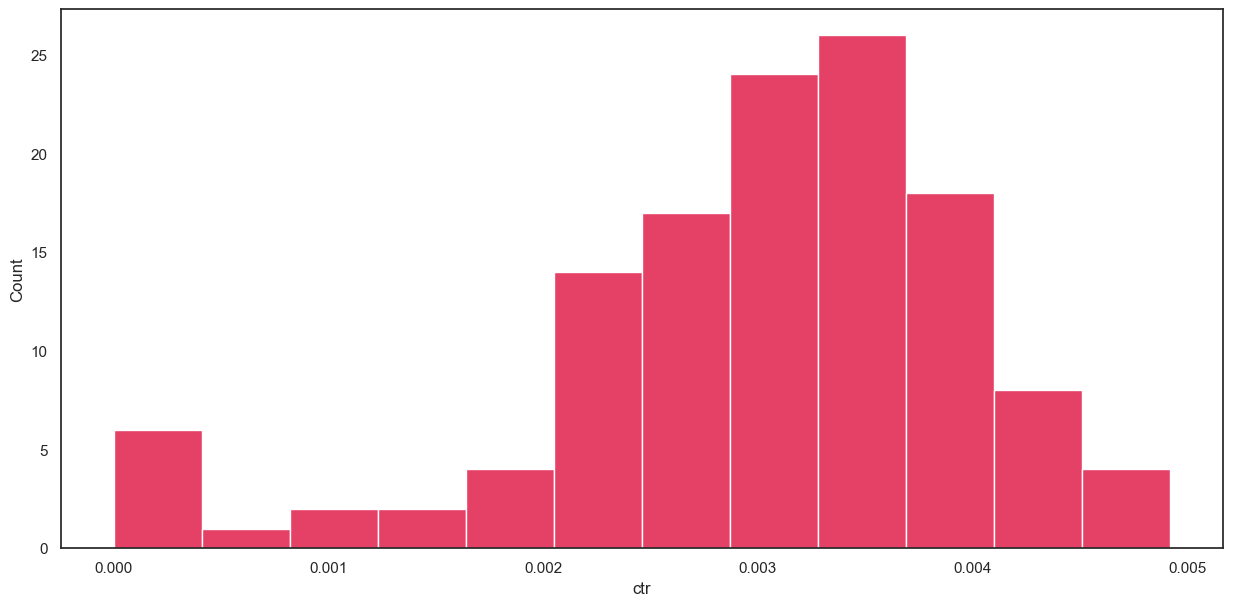

In [18]:
#create histogram of ctr
sns.histplot(in_market_group, x='ctr', kde=False)

<Axes: xlabel='clicks', ylabel='Count'>

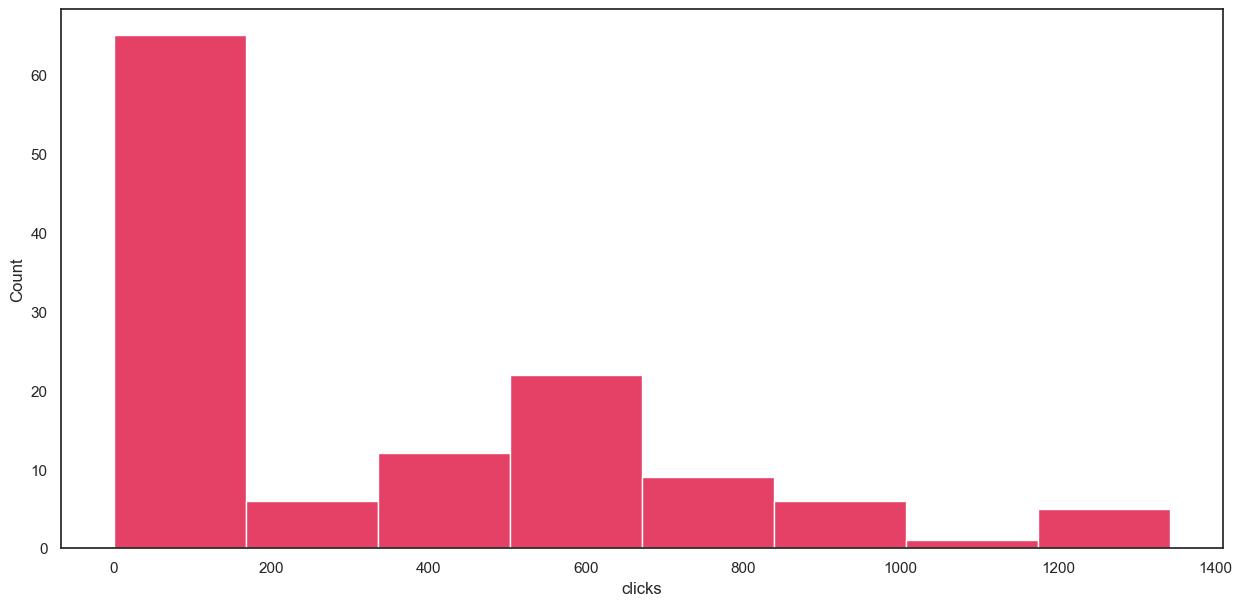

In [19]:
#create histogram of clicks
sns.histplot(in_market_group, x='clicks', kde=False)

In [20]:
#levene test of cpl - non-parametric
stats.levene(in_market_group['cpl'][in_market_group['group'] == 'Control'], 
             in_market_group['cpl'][in_market_group['group'] == 'DCO'])

LeveneResult(statistic=16.531049218052203, pvalue=8.442965909929131e-05)

In [21]:
#levene test of leads - non-parametric
stats.levene(in_market_group['3._lead:_total_conversions'][in_market_group['group'] == 'Control'], 
             in_market_group['3._lead:_total_conversions'][in_market_group['group'] == 'DCO'])

LeveneResult(statistic=10.988904459306625, pvalue=0.0012022409414379435)

In [23]:
in_market_controlgroup_cpl = in_market_group['cpl'][in_market_group['group'] == 'Control']
in_market_dcogroup_cpl = in_market_group['cpl'][in_market_group['group'] == 'DCO']

#Kruskal Wallis for cpl - stat sig
stats.kruskal(in_market_controlgroup_cpl, in_market_dcogroup_cpl)

KruskalResult(statistic=38.761137901783954, pvalue=4.789693960460967e-10)

In [24]:
#levene test of ctr - parametric
stats.levene(in_market_group['ctr'][in_market_group['group'] == 'Control'], 
             in_market_group['ctr'][in_market_group['group'] == 'DCO'])

LeveneResult(statistic=0.005060420850745784, pvalue=0.9434036157871799)

In [25]:
#levene test of clicks 
stats.levene(in_market_group['clicks'][in_market_group['group'] == 'Control'], 
             in_market_group['clicks'][in_market_group['group'] == 'DCO'])

LeveneResult(statistic=47.13267557948662, pvalue=2.826292070923397e-10)

In [27]:
#welch's t-test of ctr - stat sig
in_market_controlgroup_ctr = in_market_group['ctr'][in_market_group['group'] == 'Control']
in_market_dcogroup_ctr = in_market_group['ctr'][in_market_group['group'] == 'DCO']

t_statistic, p_value = stats.ttest_ind(in_market_controlgroup_ctr, in_market_dcogroup_ctr, equal_var=False)
p_value

0.003545629737008942

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

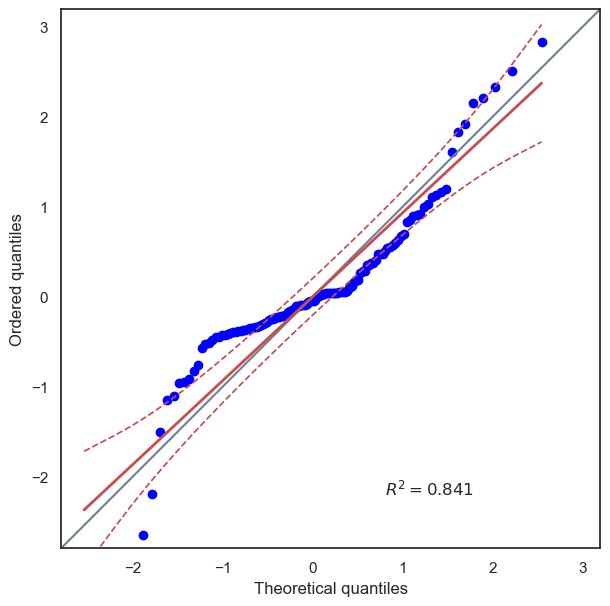

In [26]:
#check ANCOVA assumptions for clicks - residuals between the DV and covariate need to be somewhat normally distributed
#we can do ANCOVA here
ols_model = sm.OLS(in_market_group['clicks'], in_market_group[['spend', 'impressions']]).fit()
residual_values = ols_model.resid
pg.qqplot(residual_values, dist='norm')

In [29]:
#ANCOVA for clicks - findings are statistically significant
ancova(data=in_market_group, dv='clicks', covar=['spend', 'impressions'], between='group')

,Source,SS,DF,F,p-unc,np2
0,group,26037.907614,1,6.012812,1.561759e-02,0.046970
1,spend,956771.481237,1,220.942744,3.722707e-29,0.644255
2,impressions,6540.966083,1,1.510475,2.214319e-01,0.012230
3,Residual,528309.363743,122,NaN,NaN,NaN


# In-Market Performance By Version

In [35]:
in_market_version = in_market.groupby(['date', 'innovid_version_id'])[['impressions', 'clicks', 'spend', '3._lead:_total_conversions']].sum().reset_index()
in_market_version['innovid_version_id'] = in_market_version['innovid_version_id'].astype('str')
in_market_version

,date,innovid_version_id,impressions,clicks,spend,3._lead:_total_conversions
0,2023-08-07,0,2713.000000,7.000000,22.205064,0
1,2023-08-07,37,492.000000,0.000000,2.729212,0
2,2023-08-07,38,474.000000,1.000000,2.622473,0
3,2023-08-07,39,470.000000,0.000000,2.608548,0
4,2023-08-07,40,448.000000,2.000000,2.482368,0
...,...,...,...,...,...,...
2225,2023-10-13,68,8226.451582,27.999464,95.045714,0
2226,2023-10-13,69,9725.995712,41.000000,124.012406,0
2227,2023-10-13,70,6464.460288,29.999541,77.446343,0
2228,2023-10-13,71,8056.577341,24.999387,100.108644,0


In [36]:
#create calculated fields for KPIs of interest
in_market_version['ctr'] = in_market_version['clicks'] / in_market_version['impressions']
in_market_version['cvr'] = in_market_version['3._lead:_total_conversions'] / in_market_version['clicks']
in_market_version['cpl'] = in_market_version['spend'] / in_market_version['3._lead:_total_conversions']

#replace Inf and NaN values with 0
for i in in_market_version.columns:
    in_market_version[i] = in_market_version[i].replace([np.inf, -np.inf], 0)
    in_market_version[i] = in_market_version[i].replace(np.nan, 0)

In [37]:
#summary stats
in_market_version.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
impressions,2230.0,5999.483355,5811.425436,0.0,3753.878559,4855.389163,6240.226052,57540.000000
clicks,2230.0,20.079836,18.170256,0.0,10.999923,15.999694,22.999847,190.000000
spend,2230.0,56.165772,53.687420,0.0,33.628258,44.057644,61.825014,598.883408
3._lead:_total_conversions,2230.0,0.136771,0.493695,0.0,0.000000,0.000000,0.000000,7.000000
ctr,2230.0,0.003419,0.001275,0.0,0.002602,0.003353,0.004183,0.012579
cvr,2230.0,0.007159,0.031958,0.0,0.000000,0.000000,0.000000,0.750000
cpl,2230.0,7.071941,34.243157,0.0,0.000000,0.000000,0.000000,598.883408


In [38]:
in_market_versioncontrol_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '0']
in_market_version37_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '37']
in_market_version38_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '38']
in_market_version39_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '39']
in_market_version40_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '40']
in_market_version41_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '41']
in_market_version42_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '42']
in_market_version43_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '43']
in_market_version44_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '44']
in_market_version45_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '45']
in_market_version46_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '46']
in_market_version47_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '47']
in_market_version48_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '48']
in_market_version49_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '49']
in_market_version50_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '50']
in_market_version51_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '51']
in_market_version52_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '52']
in_market_version53_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '53']
in_market_version54_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '54']
in_market_version55_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '55']
in_market_version56_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '56']
in_market_version57_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '57']
in_market_version58_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '58']
in_market_version59_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '59']
in_market_version60_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '60']
in_market_version61_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '61']
in_market_version62_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '62']
in_market_version63_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '63']
in_market_version64_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '64']
in_market_version65_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '65']
in_market_version66_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '66']
in_market_version67_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '67']
in_market_version68_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '68']
in_market_version69_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '69']
in_market_version70_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '70']
in_market_version71_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '71']
in_market_version72_cpl = in_market_version['cpl'][in_market_version['innovid_version_id'] == '72']

#Kruskal Wallis for cpl - stat sig
stats.kruskal(in_market_versioncontrol_cpl, in_market_version42_cpl, in_market_version52_cpl, in_market_version37_cpl, in_market_version69_cpl)

KruskalResult(statistic=47.21171376893767, pvalue=1.3776697043578408e-09)

In [42]:
#create smaller subset of data
in_market_version_slim = in_market_version.loc[(in_market_version['innovid_version_id'] == '0') | (in_market_version['innovid_version_id'] == '42') |
                                              (in_market_version['innovid_version_id'] == '52') | (in_market_version['innovid_version_id'] == '37') |
                                              (in_market_version['innovid_version_id'] == '69')]
in_market_version_slim

,date,innovid_version_id,impressions,clicks,spend,3._lead:_total_conversions,ctr,cvr,cpl
0,2023-08-07,0,2713.000000,7.000000,22.205064,0,0.002580,0.000000,0.00000
1,2023-08-07,37,492.000000,0.000000,2.729212,0,0.000000,0.000000,0.00000
6,2023-08-07,42,483.000000,1.000000,2.681314,0,0.002070,0.000000,0.00000
16,2023-08-07,52,430.000000,0.000000,2.396774,0,0.000000,0.000000,0.00000
33,2023-08-07,69,462.000000,1.000000,2.563096,0,0.002165,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...
2193,2023-10-13,0,32971.000000,71.000000,299.365838,0,0.002153,0.000000,0.00000
2194,2023-10-13,37,9645.996577,40.000000,115.585880,0,0.004147,0.000000,0.00000
2199,2023-10-13,42,9799.632175,44.999005,117.486436,0,0.004592,0.000000,0.00000
2209,2023-10-13,52,6589.702475,25.999234,79.323210,1,0.003945,0.038463,79.32321


In [44]:
#post hoc Dunn's test on CPL
dunn_result = posthoc_dunn(in_market_version_slim, group_col='innovid_version_id', val_col='cpl', p_adjust='bonferroni')
print(dunn_result)

               0            37        42            52        69
0   1.000000e+00  2.848648e-08  0.000005  4.308552e-07  0.000013
37  2.848648e-08  1.000000e+00  1.000000  1.000000e+00  1.000000
42  4.544656e-06  1.000000e+00  1.000000  1.000000e+00  1.000000
52  4.308552e-07  1.000000e+00  1.000000  1.000000e+00  1.000000
69  1.270988e-05  1.000000e+00  1.000000  1.000000e+00  1.000000


In [46]:
#levene test of ctr - parametric
stats.levene(in_market_version['ctr'][in_market_version['innovid_version_id'] == '0'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '37'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '38'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '39'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '40'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '41'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '42'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '43'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '44'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '45'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '46'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '47'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '48'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '49'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '50'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '51'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '52'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '53'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '54'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '55'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '56'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '57'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '58'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '59'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '60'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '61'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '62'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '63'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '64'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '65'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '66'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '67'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '68'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '69'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '70'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '71'],
in_market_version['ctr'][in_market_version['innovid_version_id'] == '72'])

LeveneResult(statistic=1.0229885398285203, pvalue=0.43148591776671896)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

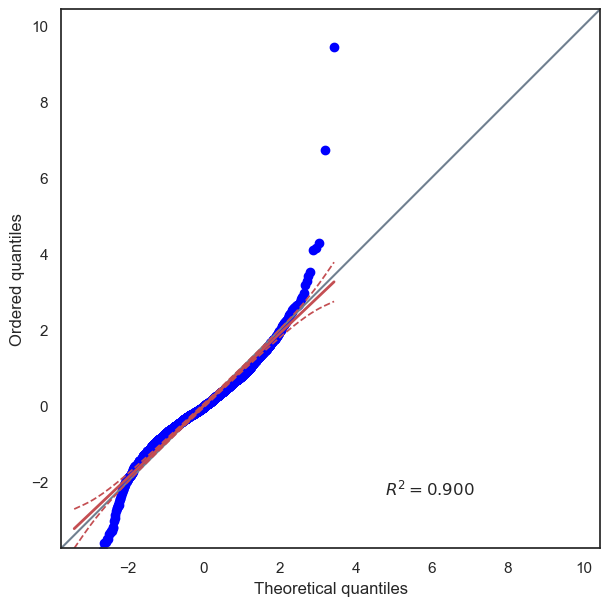

In [50]:
#check ANCOVA assumptions for clicks - residuals between the DV and covariate need to be somewhat normally distributed
#we can do ANCOVA here
ols_model = sm.OLS(in_market_version['clicks'], in_market_version[['spend', 'impressions']]).fit()
residual_values = ols_model.resid
pg.qqplot(residual_values, dist='norm')

In [52]:
#ANCOVA for clicks - findings are stat sig
ancova(data=in_market_version, dv='clicks', covar=['spend', 'impressions'], between='innovid_version_id')

,Source,SS,DF,F,p-unc,np2
0,innovid_version_id,5171.814212,36,3.788960,4.221920e-13,0.058607
1,spend,58535.887271,1,1543.838217,4.710835e-256,0.413361
2,impressions,83.214617,1,2.194720,1.386281e-01,0.001001
3,Residual,83073.554995,2191,NaN,NaN,NaN


In [53]:
#import data to R to conduct Dunnett's test on ANCOVA model
in_market_version.to_csv("In Market Version Data.csv", index=False)

# Online Shoppers Performance By Group

In [19]:
#import data
online_shoppers = pd.read_csv("Online Shoppers Wrap Up.csv")
online_shoppers.columns = online_shoppers.columns.str.replace(' ', '_')
online_shoppers.columns = [x.lower() for x in online_shoppers.columns]

#convert date object to datetime so we can slice
online_shoppers['date'] = pd.to_datetime(online_shoppers['date'])

#drop 08/13
online_shoppers = online_shoppers[online_shoppers['date'] != '2023-08-13']

online_shoppers_group = online_shoppers.groupby(['date','group'])[['impressions', 'clicks', 'spend', '3._lead:_total_conversions']].sum().reset_index()
online_shoppers_group

,date,group,impressions,clicks,spend,3._lead:_total_conversions
0,2023-08-07,Control,5967.000000,28.000000,65.630003,0
1,2023-08-07,DCO,671.000000,2.000000,6.023355,0
2,2023-08-08,Control,33074.000000,142.000000,379.751277,0
3,2023-08-08,DCO,36668.945050,227.884135,566.270796,0
4,2023-08-09,Control,43897.000000,181.000000,376.164823,1
...,...,...,...,...,...,...
123,2023-10-11,DCO,70752.663457,138.913542,616.840120,1
124,2023-10-12,Control,29177.000000,50.000000,273.913288,1
125,2023-10-12,DCO,104564.209806,184.962947,982.108553,1
126,2023-10-13,Control,28425.000000,65.000000,275.120464,0


In [20]:
#create calculated fields for KPIs of interest
online_shoppers_group['ctr'] = online_shoppers_group['clicks'] / online_shoppers_group['impressions']
online_shoppers_group['cvr'] = online_shoppers_group['3._lead:_total_conversions'] / online_shoppers_group['clicks']
online_shoppers_group['cpl'] = online_shoppers_group['spend'] / online_shoppers_group['3._lead:_total_conversions']

#replace Inf and NaN values with 0
for i in online_shoppers_group.columns:
    online_shoppers_group[i] = online_shoppers_group[i].replace([np.inf, -np.inf], 0)
    online_shoppers_group[i] = online_shoppers_group[i].replace(np.nan, 0)

#summary stats
online_shoppers_group.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
impressions,128.0,59679.261971,33245.608308,0.0,32384.250000,56121.860695,91436.275567,125069.213448
clicks,128.0,178.281043,143.484182,0.0,54.750000,137.956771,291.500000,504.855168
spend,128.0,581.944614,432.388693,0.0,233.269907,451.016120,858.507572,2430.297472
3._lead:_total_conversions,128.0,1.289062,1.522288,0.0,0.000000,1.000000,2.000000,8.000000
ctr,128.0,0.002577,0.001453,0.0,0.001514,0.002138,0.003833,0.006215
cvr,128.0,0.014924,0.030174,0.0,0.000000,0.003072,0.014968,0.162162
cpl,128.0,265.639425,396.041179,0.0,0.000000,91.693582,375.010426,2430.297472


In [21]:
#levene test of cpl - non-parametric
stats.levene(online_shoppers_group['cpl'][online_shoppers_group['group'] == 'Control'], 
             online_shoppers_group['cpl'][online_shoppers_group['group'] == 'DCO'])

LeveneResult(statistic=20.444279032199116, pvalue=1.3981438347685375e-05)

In [22]:
#levene test of leads - non-parametric
stats.levene(online_shoppers_group['3._lead:_total_conversions'][online_shoppers_group['group'] == 'Control'], 
             online_shoppers_group['3._lead:_total_conversions'][online_shoppers_group['group'] == 'DCO'])

LeveneResult(statistic=6.145928513840365, pvalue=0.014493060939027115)

In [23]:
online_shoppers_controlgroup_cpl = online_shoppers_group['cpl'][online_shoppers_group['group'] == 'Control']
online_shoppers_dcogroup_cpl = online_shoppers_group['cpl'][online_shoppers_group['group'] == 'DCO']

#Kruskal Wallis for cpl - not stat sig
stats.kruskal(online_shoppers_controlgroup_cpl, online_shoppers_dcogroup_cpl)

KruskalResult(statistic=1.5101602690019866, pvalue=0.2191146323748449)

In [10]:
#levene test of ctr - non-parametric
stats.levene(online_shoppers_group['ctr'][online_shoppers_group['group'] == 'Control'], 
             online_shoppers_group['ctr'][online_shoppers_group['group'] == 'DCO'])

LeveneResult(statistic=6.659083029902226, pvalue=0.01101129986579448)

In [11]:
#levene test of clicks - non-parametric
stats.levene(online_shoppers_group['clicks'][online_shoppers_group['group'] == 'Control'], 
             online_shoppers_group['clicks'][online_shoppers_group['group'] == 'DCO'])

LeveneResult(statistic=33.94214329999556, pvalue=4.460491802146029e-08)

In [12]:
online_shoppers_controlgroup_ctr = online_shoppers_group['ctr'][online_shoppers_group['group'] == 'Control']
online_shoppers_dcogroup_ctr = online_shoppers_group['ctr'][online_shoppers_group['group'] == 'DCO']

#Kruskal Wallis for ctr - stat sig
stats.kruskal(online_shoppers_controlgroup_ctr, online_shoppers_dcogroup_ctr)

KruskalResult(statistic=32.637188688852376, pvalue=1.1106910757092057e-08)

In [13]:
#welch's t-test of ctr - stat sig
t_statistic, p_value = stats.ttest_ind(online_shoppers_controlgroup_ctr, online_shoppers_dcogroup_ctr, equal_var=False)
p_value

1.1509504746444213e-09

In [458]:
#calculate skew and kurtosis of cvr
print(skew(in_market_version['cvr_transformed'], bias=False))
print(kurtosis(in_market_version['cvr_transformed'], bias=False))

3.796373749245757
16.782683342220707


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

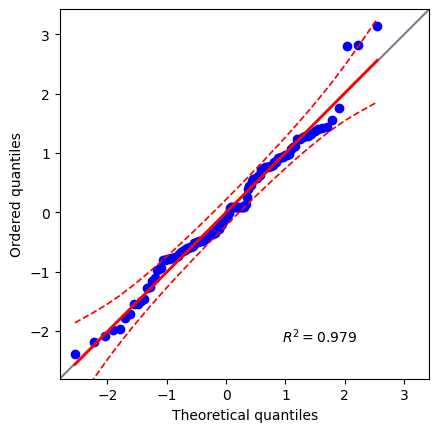

In [14]:
#check ANCOVA assumptions for clicks - residuals between the DV and covariate need to be somewhat normally distributed
#we can do ANCOVA here
ols_model = sm.OLS(online_shoppers_group['clicks'], online_shoppers_group[['spend', 'impressions']]).fit()
residual_values = ols_model.resid
pg.qqplot(residual_values, dist='norm')

In [15]:
#ANCOVA for clicks - findings are stat sig
ancova(data=online_shoppers_group, dv='clicks', covar=['spend', 'impressions'], between='group')

,Source,SS,DF,F,p-unc,np2
0,group,134896.983598,1,32.508696,8.205286e-08,0.207712
1,spend,147285.692510,1,35.494239,2.461998e-08,0.222542
2,impressions,4560.527686,1,1.099037,2.965165e-01,0.008785
3,Residual,514546.205185,124,NaN,NaN,NaN


# Online Shoppers Performance By Version

In [16]:
online_shoppers_version = online_shoppers.groupby(['date','innovid_version_id'])[['impressions', 'clicks', 'spend', '3._lead:_total_conversions']].sum().reset_index()
online_shoppers_version

,date,innovid_version_id,impressions,clicks,spend,3._lead:_total_conversions
0,2023-08-07,0,5968.000000,28.0,65.644398,0
1,2023-08-07,1,16.000000,0.0,0.144644,0
2,2023-08-07,2,19.000000,0.0,0.175250,0
3,2023-08-07,3,18.000000,0.0,0.150178,0
4,2023-08-07,4,21.000000,0.0,0.191937,0
...,...,...,...,...,...,...
2191,2023-10-13,32,3651.991079,1.0,31.686851,0
2192,2023-10-13,33,2264.799618,3.0,19.245817,0
2193,2023-10-13,34,2091.559277,2.0,17.875033,0
2194,2023-10-13,35,2332.989902,3.0,19.650439,0


In [120]:
#create calculated fields for KPIs of interest
online_shoppers_version['ctr'] = online_shoppers_version['clicks'] / online_shoppers_version['impressions']
online_shoppers_version['cvr'] = online_shoppers_version['3._lead:_total_conversions'] / online_shoppers_version['clicks']
online_shoppers_version['cpl'] = online_shoppers_version['spend'] / online_shoppers_version['3._lead:_total_conversions']

#replace Inf and NaN values with 0
for i in online_shoppers_version.columns:
    online_shoppers_version[i] = online_shoppers_version[i].replace([np.inf, -np.inf], 0)
    online_shoppers_version[i] = online_shoppers_version[i].replace(np.nan, 0)

In [121]:
#summary stats
online_shoppers_version.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
innovid_version_id,2196.0,17.945355,10.697571,0.0,9.000000,18.000000,27.000000,36.000000
impressions,2196.0,3478.697874,7603.924416,0.0,1867.482362,2396.479853,2897.239884,96998.000000
clicks,2196.0,10.392064,16.422334,0.0,5.000000,8.000000,11.000000,223.000000
spend,2196.0,27.569300,57.968731,0.0,13.704207,18.267572,24.863215,727.480462
3._lead:_total_conversions,2196.0,0.075137,0.450058,0.0,0.000000,0.000000,0.000000,8.000000
ctr,2196.0,0.003565,0.002611,0.0,0.002182,0.003426,0.004622,0.066667
cvr,2196.0,0.004530,0.035361,0.0,0.000000,0.000000,0.000000,1.000000
cpl,2196.0,4.471359,35.437614,0.0,0.000000,0.000000,0.000000,627.635968


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

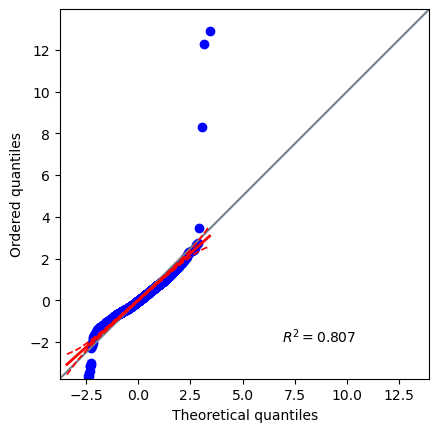

In [17]:
#check ANCOVA assumptions for leads - residuals between the DV and covariate need to be somewhat normally distributed
#we can do ANCOVA here
ols_model = sm.OLS(online_shoppers_version['clicks'], online_shoppers_version[['spend', 'impressions']]).fit()
residual_values = ols_model.resid
pg.qqplot(residual_values, dist='norm')

In [18]:
#ANCOVA for leads - findings are stat sig
ancova(data=online_shoppers_version, dv='clicks', covar=['spend', 'impressions'], between='innovid_version_id')

,Source,SS,DF,F,p-unc,np2
0,innovid_version_id,1649.149271,36,1.687006,6.676927e-03,0.027385
1,spend,60562.703386,1,2230.306030,0.000000e+00,0.508354
2,impressions,5766.386379,1,212.355222,5.962997e-46,0.089626
3,Residual,58572.119439,2157,NaN,NaN,NaN


In [129]:
#export data for post-hoc testing in R
online_shoppers_version.to_csv("Online Shoppers Version Data.csv", index=False)